In [1]:
import control
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import x1sim
import foton
from timeit import default_timer as timer

# Load plant models
plant_par1 = np.load("model_params/plant1.npz")
plant_par2 = np.load("model_params/plant2.npz")
plant_par3 = np.load("model_params/plant3.npz")
# plant_par = np.load("model_params/test_plant.npz")

# Load controller (test only)
controller_par = np.load("model_params/test_controller.npz")

# Load disturbance and noise
disturbance_par = np.load("model_params/disturbance.npz")
noise_par = np.load("model_params/noise.npz")

plant_z = np.concatenate((plant_par1["zs"], plant_par2["zs"], plant_par3["zs"]))
plant_p = np.concatenate((plant_par1["ps"], plant_par2["ps"], plant_par3["ps"]))
plant_k = plant_par1["k"] * plant_par2["k"] * plant_par3["k"]

# plant_z = plant_par["zs"]
# plant_p = plant_par["ps"]
# plant_k = plant_par["k"]

controller_z = controller_par["zs"]
controller_p = controller_par["ps"]
controller_k = controller_par["k"]

disturbance_z = disturbance_par["zs"]
disturbance_p = disturbance_par["ps"]
disturbance_k = disturbance_par["k"]

noise_z = noise_par["zs"]
noise_p = noise_par["ps"]
noise_k = noise_par["k"]

def zpk2tf(z, p, k):
    b, a = scipy.signal.zpk2tf(z, p, k)
    return control.tf(b, a)

plant_tf = zpk2tf(plant_z, plant_p, plant_k)
controller_tf = zpk2tf(controller_z, controller_p, controller_k)
disturbance_tf = zpk2tf(disturbance_z, disturbance_p, disturbance_k)
noise_tf = zpk2tf(noise_z, noise_p, noise_k)

In [2]:


arm = x1sim.x1sim()

sens       = arm.LIGOFilter('SENS')
ctrl       = arm.LIGOFilter('CTRL')
act        = arm.LIGOFilter('ACT')
plant      = arm.LIGOFilter('PLANT')
sens_noise = arm.LIGOFilter('SENS_NOISE')
seis_noise = arm.LIGOFilter('SEIS_NOISE')


# What is ramp gain?
sens.ramp_gain(1, 0)
act.ramp_gain(1, 0)
# ctrl.ramp_gain(1, 0)
# plant.ramp_gain(1, 0)


# set filters

# Load plant models

arm.fm_set_zpk('PLANT', 'FM3', plant_par1['zs'], plant_par1['ps'], plant_par1['k'])
arm.fm_set_zpk('PLANT', 'FM4', plant_par2['zs'], plant_par2['ps'], float(plant_par2['k']))
arm.fm_set_zpk('PLANT', 'FM5', plant_par3['zs'], plant_par3['ps'], plant_par3['k'])

plant.turn_on('FM3')  # what does this do?
plant.turn_on("FM4")
plant.turn_on("FM5")

# arm.fm_set_zpk('PLANT', 'FM3', plant_par['zs'], plant_par['ps'], plant_par['k'])
# plant.turn_on('FM3')
plant.ramp_gain(1, 0)

# Load controllers
filter_file = foton.FilterFile("foton_files/L1LSC.txt")
srcl_module = filter_file["LSC_SRCL"]
fms_that_are_on = [1, 2, 3, 4, 7, 9, 10]

for fmnum in fms_that_are_on:
    z, p, k = srcl_module[fmnum - 1].get_zpk()
    arm.fm_set_zpk('CTRL', f'FM{fmnum}',  z, p, k)
    
for fmnum in fms_that_are_on:
    ctrl.turn_on(f"FM{fmnum}")

ctrl.ramp_gain(-0.4*10, 0)
# ctrl.ramp_gain(1, 0)


# arm.fm_set_zpk('CTRL', 'FM3', controller_par['zs'], controller_par['ps'], controller_par['k'])
# ctrl.turn_on("FM3")
# ctrl.ramp_gain(-1, 0)

# Set seismic noises

fs = arm.sample_rate
unit_amplitude = np.sqrt(fs/2)

# disturbance_par = np.load("model_params/disturbance.npz")
arm.fm_set_zpk("SEIS_NOISE", "FM3", disturbance_par["zs"], disturbance_par["ps"], disturbance_par["k"])
seis_noise.turn_on("FM3")
seis_noise.ramp_gain(unit_amplitude, 0)


# Set sensor noise
# noise_par = np.load("model_params/noise.npz")
# arm.fm_set_zpk("SENS_NOISE", "FM3", noise_par["zs"], noise_par["ps"], noise_par["k"])
# sens_noise.turn_on("FM3")
sens_noise.ramp_gain(unit_amplitude*noise_par["k"], 0)
# sens_noise.ramp_gain(1, 0)


# start excitations
# duration = 3600
# fs = arm.sample_rate
# unit_amplitude = np.sqrt(fs/2)
# size = int(duration*arm.sample_rate)
# white_noise1 = np.random.normal(loc=0, scale=unit_amplitude, size=size)
# white_noise2 = np.random.normal(loc=0, scale=unit_amplitude, size=size)
# sens_noise_exc = arm.awg.ArbitraryStream('SENS_NOISE_EXC', rate=arm.sample_rate)
# seis_noise_exc = arm.awg.ArbitraryStream('SEIS_NOISE_EXC', rate=arm.sample_rate)
# sens_noise_exc.append(white_noise1)
# seis_noise_exc.append(white_noise2)

# fetch data.
arm.sleep(0)  # settle time
dur = 1200
t0 = timer()
chan_names = ['PLANT_OUT', 'SENS_OUT','CTRL_OUT', 'SEIS_NOISE_OUT', 'SENS_NOISE_OUT', "PLANT_IN1", "CTRL_IN1"]
bufs = arm.fetch(0, dur, chan_names)
print("Took {:0.1f} s to get ".format(timer()-t0) + str(dur) + " s of sim data.")




Took 2.6 s to get 1200 s of sim data.


In [3]:
plant_out = bufs[0].data
plant_in = bufs[5].data
ctrl_out = bufs[2].data
ctrl_in = bufs[6].data
sens_out = bufs[4].data
seis_out = bufs[3].data

In [4]:
f, seis_asd = scipy.signal.welch(seis_out, fs=fs, nperseg=(len(bufs[0].data)/5))
f, sens_asd = scipy.signal.welch(sens_out, fs=fs, nperseg=(len(bufs[0].data)/5))
f, plant_asd = scipy.signal.welch(plant_out, fs=fs, nperseg=(len(bufs[0].data)/5))
f, ctrl_asd = scipy.signal.welch(ctrl_out, fs=fs, nperseg=(len(bufs[0].data)/5))
f, ctrl_in_asd = scipy.signal.welch(ctrl_in, fs=fs, nperseg=(len(bufs[0].data)/5))

f, csd = scipy.signal.csd(ctrl_in, ctrl_out, fs=fs, nperseg=(len(bufs[0].data)/5))

ctrl_tf = csd / ctrl_in_asd
coh = abs(csd)**2 / ctrl_in_asd / ctrl_asd
ctrl_asd = ctrl_asd**.5
ctrl_in_asd = ctrl_in_asd**.5
plant_asd = plant_asd**.5
seis_asd = seis_asd**.5
sens_asd = sens_asd**.5

In [5]:
import vishack


data2 = vishack.data.diaggui.Diaggui("data/241113-SRCL_IN_OUT.xml")

f__, srcl_in = data2.psd("L1:LSC-SRCL_IN1_DQ")
f__, srcl_out = data2.psd("L1:LSC-SRCL_OUT_DQ")

f__, srcl_in_out = data2.tf("L1:LSC-SRCL_IN1_DQ", "L1:LSC-SRCL_OUT_DQ")

Text(0.5, 0, 'Frequency (Hz)')

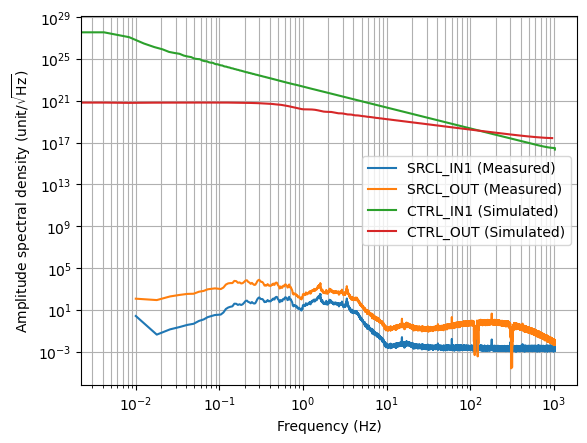

In [6]:
# plt.loglog(f, abs(disturbance_tf(1j*2*np.pi*f)))
plt.loglog(f__, srcl_in, label="SRCL_IN1 (Measured)")
plt.loglog(f__, srcl_out, label="SRCL_OUT (Measured)")
plt.loglog(f, ctrl_in_asd, label="CTRL_IN1 (Simulated)", visible=True)
plt.loglog(f[f<950], ctrl_asd[f<950], label="CTRL_OUT (Simulated)", visible=True)

plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel(r"Amplitude spectral density (unit/$\sqrt{\mathrm{Hz}}$)")
plt.xlabel("Frequency (Hz)")
# plt.loglog(f, abs(noise_tf(1j*2*np.pi*f)))
# plt.loglog(f, sens_asd)

/tmp/ipykernel_578628/3455331891.py:1: RuntimeWarning: invalid value encountered in multiply
  plt.semilogx(f, np.angle(ctrl_tf*10*.4*plant_tf(1j*2*np.pi*f)))


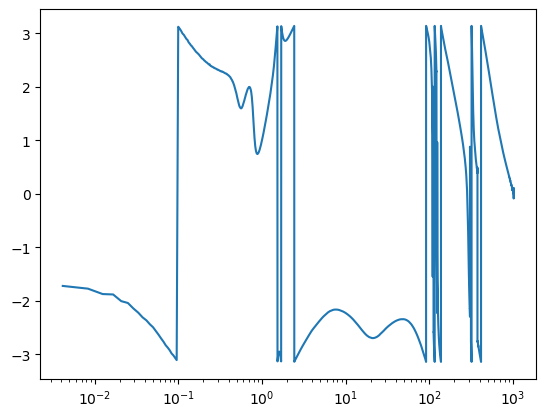

In [19]:
plt.semilogx(f, np.angle(ctrl_tf*10*.4*plant_tf(1j*2*np.pi*f)))
# plt.semilogx(f, np.angle(plant_tf(1j*2*np.pi*f)))

In [6]:
oltf = controller_tf*plant_tf
supp = abs((plant_tf/(1+oltf))(1j*2*np.pi*f))  * abs(disturbance_tf(1j*2*np.pi*f))
inj = abs((oltf/(1+oltf))(1j*2*np.pi*f))  * abs(noise_tf(1j*2*np.pi*f))
expect = (supp**2 + inj**2)**.5

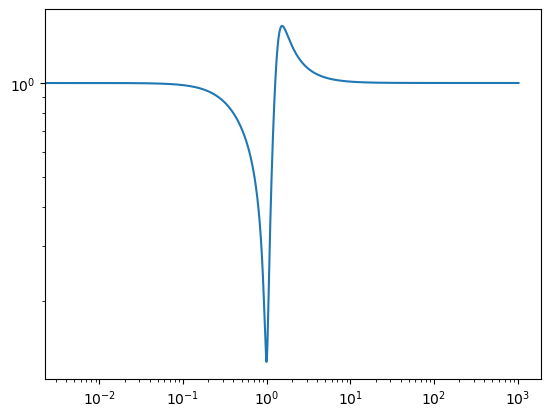

In [40]:
plt.loglog(f, abs((1/(1+oltf))(1j*2*np.pi*f)))

In [7]:
np.mean(sens)*32

np.float64(0.07366260525595017)

In [8]:
1/np.sqrt(fs/2)

np.float64(0.03125)

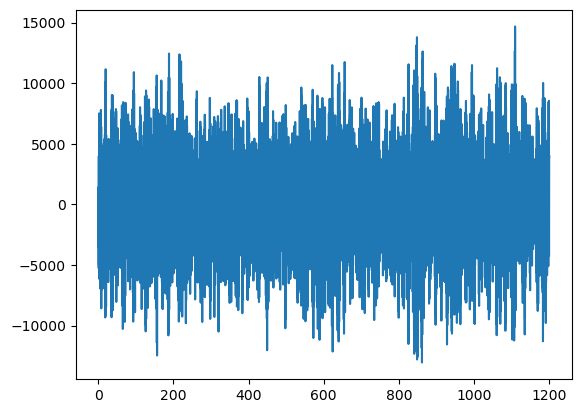

In [9]:
t = np.linspace(0, dur, len(bufs[0].data))
plt.plot(t, bufs[0].data)